In [1]:
# gotta import the things I think I'll need
import numpy as np
import pandas as pd
import nilearn as nil
import os
import re
from sklearn.preprocessing import normalize
from nilearn.input_data import NiftiMasker 
# Change dir so I'm working from the top level
os.chdir('../..')
output_dir='MVPA/data/'
behave_input='Behavior/EV_files_GuessingGame'
mr_input='guessinggame/'

/usr/local/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Python2 support is deprecated and will be removed in a future release. Consider switching to Python3.
  after removing the cwd from sys.path.


In [2]:
part_list=os.listdir(mr_input)
part_list.remove('120')
if os.path.exists(output_dir+'sub'):

    trial_img_list=[]
    normalize=NiftiMasker(standardize=True)
    #making and moving data files

    for sub in part_list:
        sub_out=output_dir+'sub-'+sub+'/'
        if not os.path.exists(sub_out):
            os.makedirs(sub_out)
        print(sub)
        sub_files=[]
        for root,dirs,files in os.walk(mr_input+sub):
            for f in files:
                if f.endswith("nii.gz"):
                    sub_files.append(os.path.join(root,f))
        sub_files.sort()

        full_image=nil.image.load_img(sub_files)
        func_img_name=sub_out+'DelgadoCard_func.nii.gz'
        full_image.to_filename(func_img_name)
        run1=[]
        run2=[]
        for run in [1,2]:

            for label_type in ['gain','loss','neutral','lapse']:
                file_name=behave_input+'/'+sub+'/run%s/%s.txt'%(run,label_type)

                if os.path.exists(file_name):
                    dat=np.loadtxt(file_name)


                    if np.logical_and(run==1,len(dat)):
                        label=[]
                        run_label=[]
                        if len(dat.shape)>1:
                            for row in dat:
                                run_label.append(['run%s'%(run)])
                                label.append([label_type])
                            data=np.hstack((dat,run_label,label))
                            run1.append(data)
                        else:
                            data=np.hstack((dat,run,label_type))
                            data=data[None,:]
                            run1.append(data)
                    if np.logical_and(run==2,len(dat)):
                        label=[]
                        run_label=[]
                        if len(dat.shape)>1:
                            for row in dat:
                                run_label.append(['run%s'%(run)])
                                label.append([label_type])
                            data=np.hstack((dat,run_label,label))
                            run2.append(data)
                        else:
                            data=np.hstack((dat,run,label_type))
                            data=data[None,:]
                            run2.append(data)

        run1=np.concatenate(run1)
        run2=np.concatenate(run2)
        cols=['onset','dur','para','run','label']
        r1_df=pd.DataFrame(run1,columns=cols)
        r1_df['sub']=sub
        r1_df.onset=pd.to_numeric(r1_df.onset)
        r1_df=r1_df.sort_values(by='onset').reset_index(drop=True)
        r2_df=pd.DataFrame(run2,columns=cols)
        r2_df['sub']=sub
        r2_df.onset=pd.to_numeric(r2_df.onset)
        r2_df=r2_df.sort_values(by='onset').reset_index(drop=True)
        runs_df=pd.concat([r1_df,r2_df])
        runs_df.to_csv(sub_out+'Delgado_card_behavior.csv',sep='\t')


In [3]:
func_list=[]
label_list=[]
#List of labels

        
for sub in part_list:
    print sub
    func_list.append('/data/projects/highressingletrial/MVPA/data/sub-%s/DelgadoCard_func.nii.gz'%(sub))
    label_list.append(
        pd.read_csv('/data/projects/highressingletrial/MVPA/data/sub-%s/Delgado_card_behavior.csv'%(sub)
                   ,sep='\t',index_col=0,
                    header=0))


124
118
114
115
106
113
125
110
104
112
111
116
119
121
117
122
123
109


In [4]:
from nilearn import datasets,image,masking,signal,plotting,input_data
import matplotlib.pyplot as plt
if 'MVPA' in os.listdir('.'):
    os.chdir('MVPA')
#We use the 7 area choi atlas
atlas_name='code/Choi_JNeurophysiol12_MNI152/Choi2012_7Networks_MNI152_FreeSurferConformed1mm_TightMask.nii.gz'
choi=image.load_img(atlas_name)
choi_list=[]
#Here we are turning the choi atlas based on intensity into a list of images where each intensity
# is a seperate image
func=image.load_img(func_list[0])
mean_img=image.image.mean_img(func)
for index in range(7):
    current_area=image.math_img('img==%s'%(index+1),img=choi)
    resampled_area=image.resample_to_img(current_area,mean_img,interpolation='linear')
    choi_list.append(resampled_area)
    
choi_maps=image.concat_imgs(choi_list)
choi_maps.to_filename("choi_atlas_4d.nii.gz")
#just plotting the atlas so we have an idea of what things look like
plotting.plot_roi(atlas_name,colorbar=True)
plt.show()

#make a list of masker objects to loop through later
mask_list=[]
masked_img_data=[]

for img in choi_list:
    mask=input_data.NiftiMasker(mask_img=img)
    mask_list.append(mask)
#make a list of 4d data images relating to each area of the 4d choi atlas
#for i,current_masker in enumerate(mask_list):
    #temp_data=current_masker.fit_transform(func_total)
    #current_masker.inverse_transform(temp_data).to_filename('masked_choi_%s.nii.gz'%(i))
    #masked_img_data.append(temp_data)
    

/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/utils/graph.py:15: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .graph_shortest_path import graph_shortest_path  # noqa
/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/base.py:35: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ..utils.seq_dataset import ArrayDataset, CSRDataset
/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:23: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ..utils import arrayfuncs, as_float_array, check_X_y, deprecated
/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:29: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import cd_fast
/usr/local/anaconda2/lib/python2.7/site-pac

<Figure size 730x260 with 5 Axes>

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .linbin import fast_linbin
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:11: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._smoothers_lowess import lowess as _lowess
/usr/local/anaconda2/lib/python2.7/site-packages/scipy/cluster/vq.py:78: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _vq
/usr/local/anaconda2/lib/python2.7/site-packages/scipy/cluster/hierarchy.py:178: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _hierarchy, _optimal_leaf_ordering


[124] /data/projects/highressingletrial/MVPA/data/sub-124/DelgadoCard_func.nii.gz
0.2111111111111111


,PC1,PC2,PC3
type,,,
gain,0.083894,-0.046327,0.067619
lapse,0.052631,0.158875,0.041251
loss,-0.157461,0.042592,-0.068975
neutral,0.061956,-0.023786,-0.005802


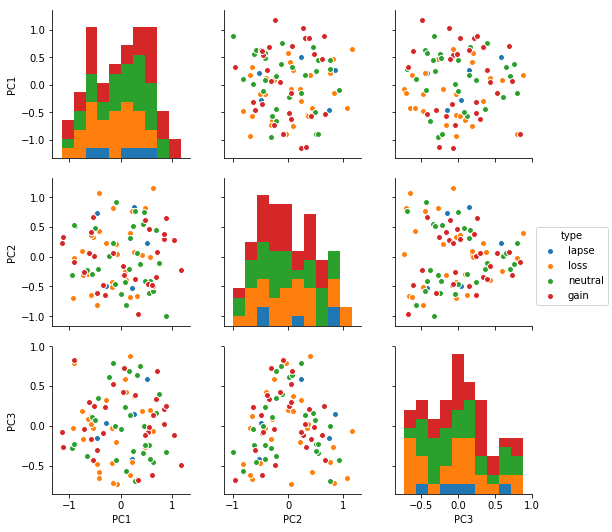

[118] /data/projects/highressingletrial/MVPA/data/sub-118/DelgadoCard_func.nii.gz
0.2111111111111111


,PC1,PC2,PC3
type,,,
gain,0.041543,0.027967,0.029651
lapse,-0.039498,-0.397299,0.022621
loss,0.101615,0.103463,0.009982
neutral,-0.133151,0.063869,-0.051408


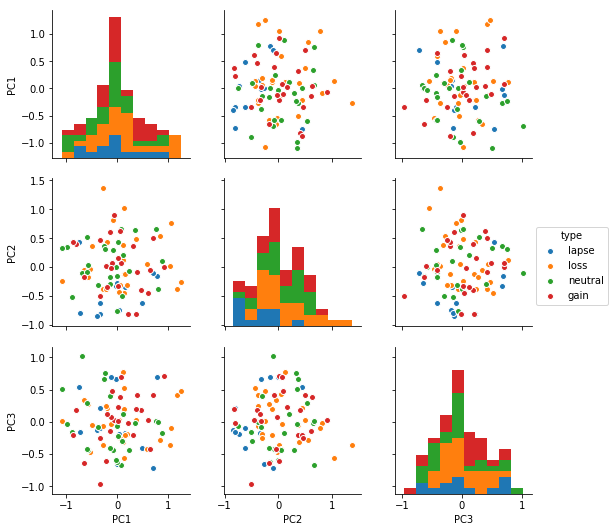

[114] /data/projects/highressingletrial/MVPA/data/sub-114/DelgadoCard_func.nii.gz
0.2777777777777778


,PC1,PC2,PC3
type,,,
gain,-0.158669,0.081640,-0.018709
lapse,0.470796,0.189089,0.059014
loss,0.143046,-0.093424,0.009893
neutral,-0.055684,-0.027261,-0.000677


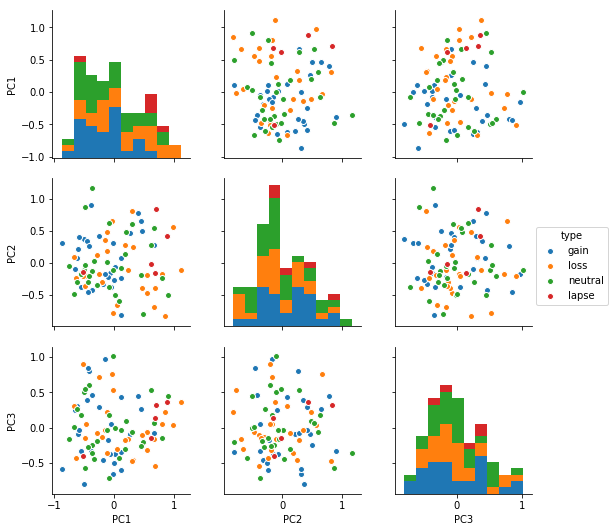

[115] /data/projects/highressingletrial/MVPA/data/sub-115/DelgadoCard_func.nii.gz
0.022222222222222223


,PC1,PC2,PC3
type,,,
gain,-0.052655,-0.129209,-0.022167
lapse,0.159982,0.512217,0.055048
loss,-0.039728,-0.044793,-0.019487
neutral,0.042086,0.005112,0.024951


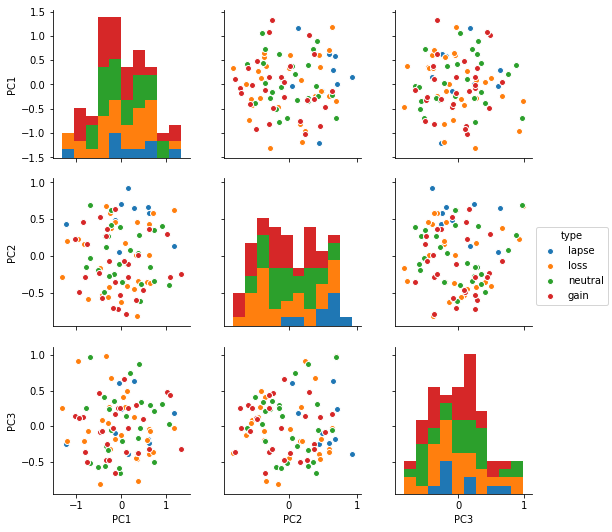

[106] /data/projects/highressingletrial/MVPA/data/sub-106/DelgadoCard_func.nii.gz
0.14444444444444443


,PC1,PC2,PC3
type,,,
gain,0.009984,-0.040530,-0.055007
lapse,0.057819,-0.308118,0.112132
loss,-0.015791,0.035792,0.013224
neutral,0.001759,0.025121,0.032915


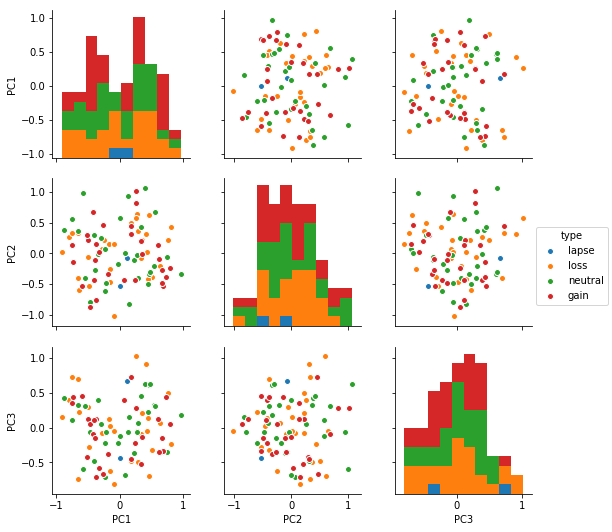

[113] /data/projects/highressingletrial/MVPA/data/sub-113/DelgadoCard_func.nii.gz
0.3


,PC1,PC2,PC3
type,,,
gain,0.079034,0.129508,0.179321
lapse,-0.054074,0.162634,-0.211477
loss,0.097899,-0.044803,0.028935
neutral,-0.150567,-0.173988,-0.090986


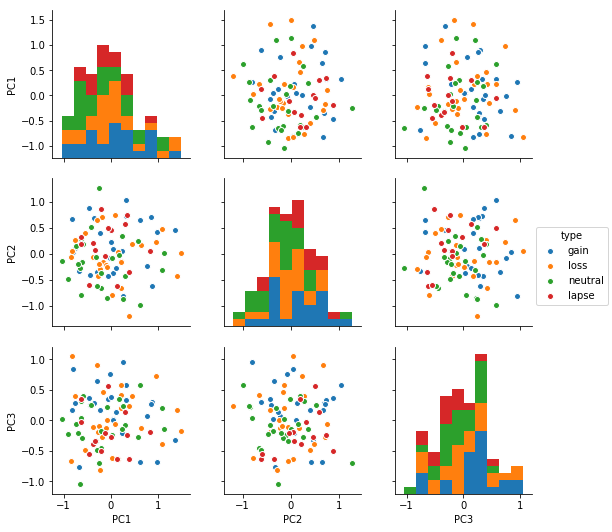

[125] /data/projects/highressingletrial/MVPA/data/sub-125/DelgadoCard_func.nii.gz
0.07777777777777778


,PC1,PC2,PC3
type,,,
gain,0.010978,0.009690,0.057046
lapse,-0.058804,0.372912,-0.458364
loss,-0.056575,-0.025523,0.003318
neutral,0.045746,-0.010729,-0.029585


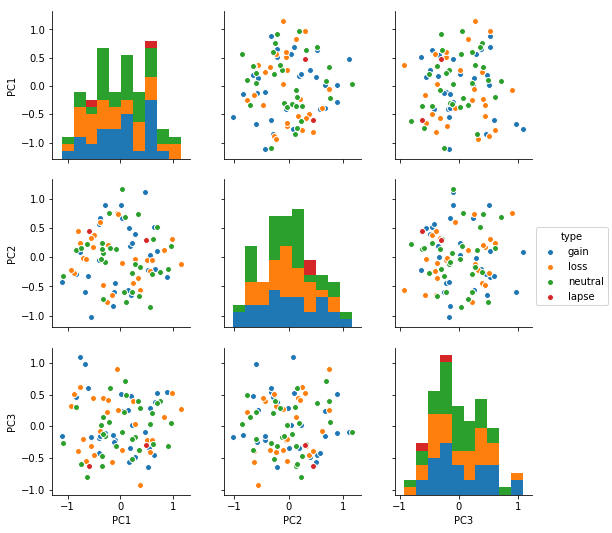

[110] /data/projects/highressingletrial/MVPA/data/sub-110/DelgadoCard_func.nii.gz
0.26666666666666666


,PC1,PC2,PC3
type,,,
gain,0.030729,-0.087659,-0.073100
lapse,0.010694,-0.016796,0.010276
loss,0.146463,0.067604,0.033863
neutral,-0.172747,0.036885,0.034958


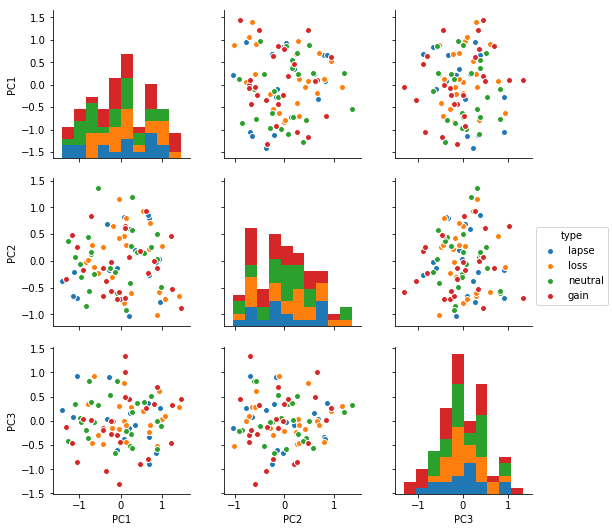

[104] /data/projects/highressingletrial/MVPA/data/sub-104/DelgadoCard_func.nii.gz
0.1111111111111111


,PC1,PC2,PC3
type,,,
gain,-0.030083,0.005989,-0.028138
lapse,-0.804589,0.232415,-0.074590
loss,0.117602,-0.005316,0.043110
neutral,-0.056780,-0.008597,-0.011049


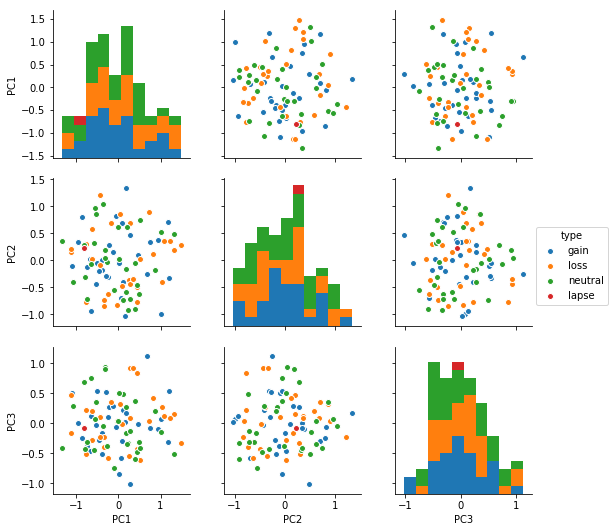

[112] /data/projects/highressingletrial/MVPA/data/sub-112/DelgadoCard_func.nii.gz
0.12222222222222222


,PC1,PC2,PC3
type,,,
gain,-0.006002,-0.084429,-0.050947
lapse,0.045855,0.194204,0.014380
loss,0.016967,0.020692,-0.006196
neutral,-0.021277,0.012465,0.049731


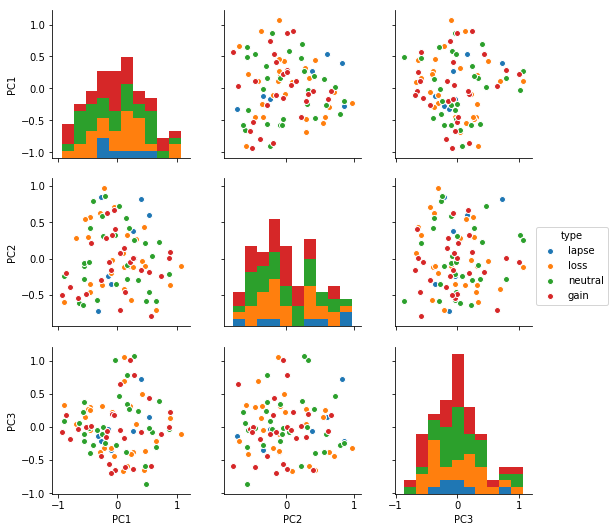

[111] /data/projects/highressingletrial/MVPA/data/sub-111/DelgadoCard_func.nii.gz
0.2222222222222222


,PC1,PC2,PC3
type,,,
gain,0.040232,-0.061527,-0.081896
lapse,-0.134809,0.242470,-0.152292
loss,0.101967,-0.059577,0.058084
neutral,-0.089558,0.043877,0.071011


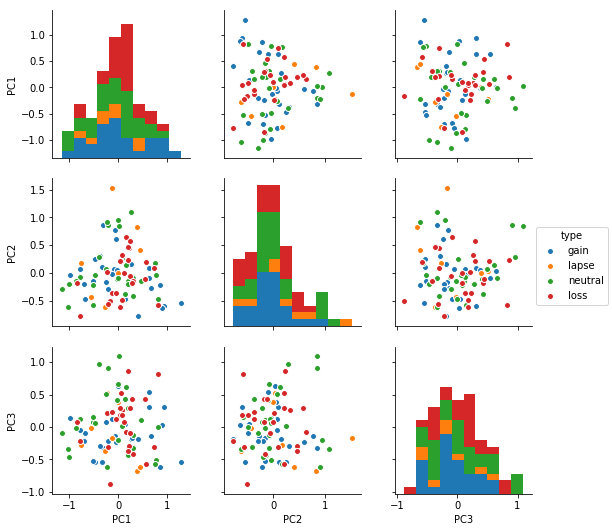

[116] /data/projects/highressingletrial/MVPA/data/sub-116/DelgadoCard_func.nii.gz
0.2777777777777778


,PC1,PC2,PC3
type,,,
gain,-0.024256,0.004182,0.057241
lapse,0.495050,-0.092292,0.705852
loss,-0.065573,-0.068121,-0.132087
neutral,0.055209,0.070371,0.031605


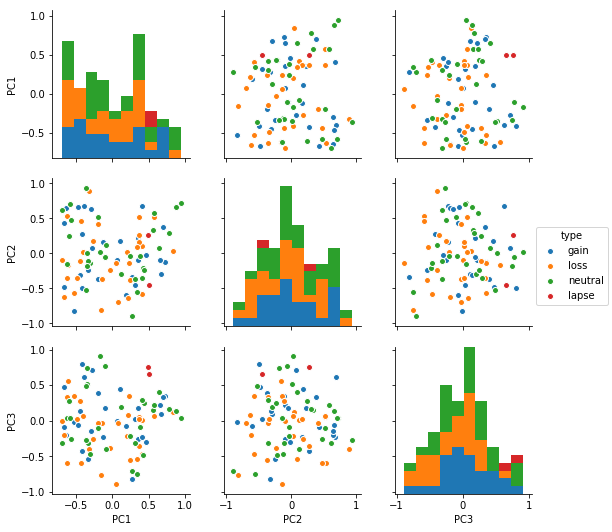

[119] /data/projects/highressingletrial/MVPA/data/sub-119/DelgadoCard_func.nii.gz
0.28888888888888886


,PC1,PC2,PC3
type,,,
gain,0.004169,-0.009780,-0.043562
lapse,-0.173212,0.195576,0.395090
loss,-0.016926,-0.054394,0.001223
neutral,0.056574,0.012541,-0.055206


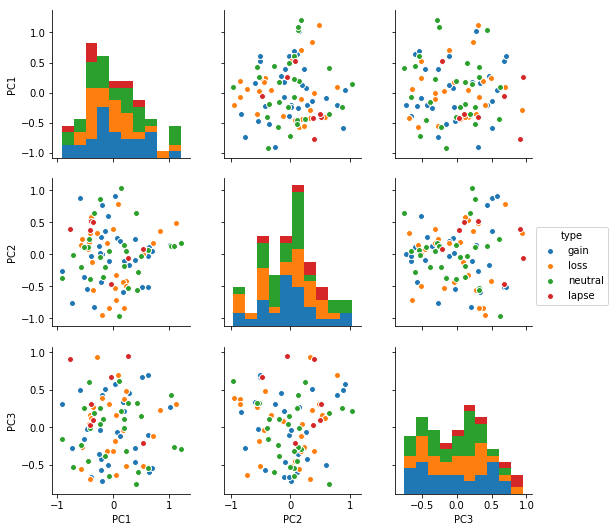

[121] /data/projects/highressingletrial/MVPA/data/sub-121/DelgadoCard_func.nii.gz
0.34444444444444444


,PC1,PC2,PC3
type,,,
gain,0.002396,-0.031325,0.038126
lapse,0.342924,-0.388068,-0.220166
loss,-0.082617,0.126142,0.031239
neutral,0.020633,-0.030111,-0.026546


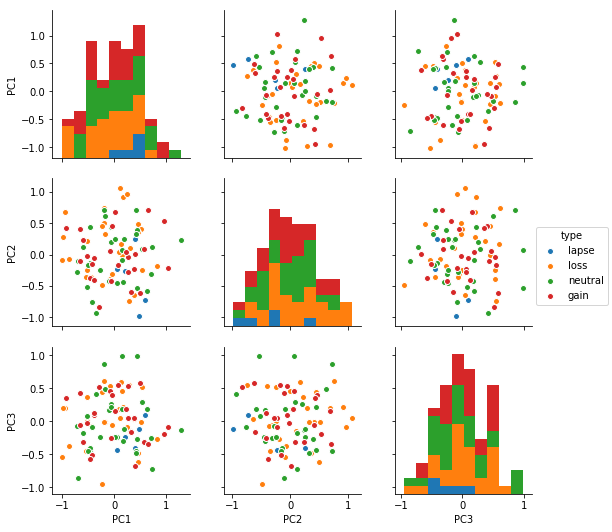

[117] /data/projects/highressingletrial/MVPA/data/sub-117/DelgadoCard_func.nii.gz
0.13333333333333333


,PC1,PC2,PC3
type,,,
gain,-0.065972,0.037918,-0.117604
lapse,-0.079354,-0.174177,0.628636
loss,0.002270,-0.023391,0.039012
neutral,0.069557,0.005605,0.008160


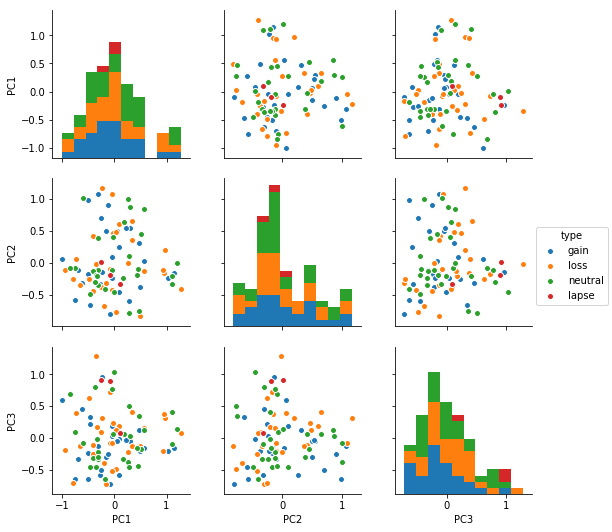

[122] /data/projects/highressingletrial/MVPA/data/sub-122/DelgadoCard_func.nii.gz
0.3


,PC1,PC2,PC3
type,,,
gain,-0.023155,0.063676,-0.044327
lapse,0.603020,0.224029,-0.013464
loss,-0.103670,-0.035530,0.061902
neutral,0.064443,-0.051321,-0.016182


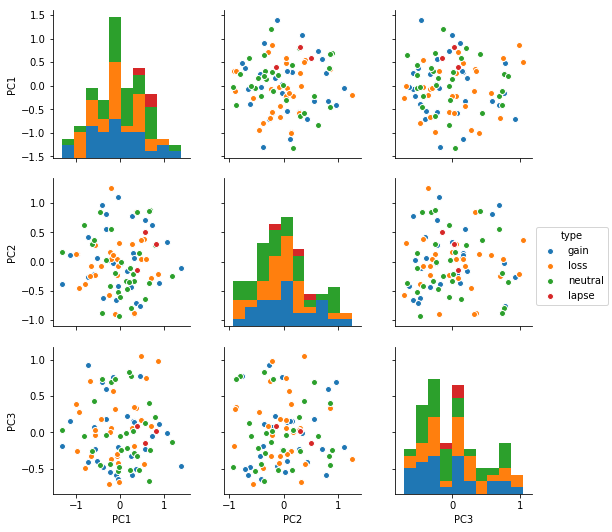

[123] /data/projects/highressingletrial/MVPA/data/sub-123/DelgadoCard_func.nii.gz
0.13333333333333333


,PC1,PC2,PC3
type,,,
gain,0.040674,-0.016423,0.013552
lapse,0.072178,-0.273668,-0.121118
loss,-0.131481,0.062160,0.080444
neutral,0.046246,0.060882,-0.039248


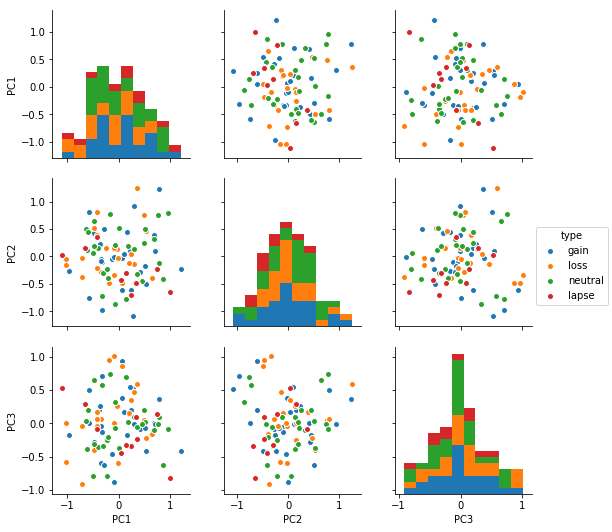

[109] /data/projects/highressingletrial/MVPA/data/sub-109/DelgadoCard_func.nii.gz
0.011111111111111112


,PC1,PC2,PC3
type,,,
gain,-0.009922,0.020399,-0.045151
lapse,0.324557,0.093697,-0.086346
loss,-0.037616,-0.049743,0.065517
neutral,-0.089393,-0.011082,0.017901


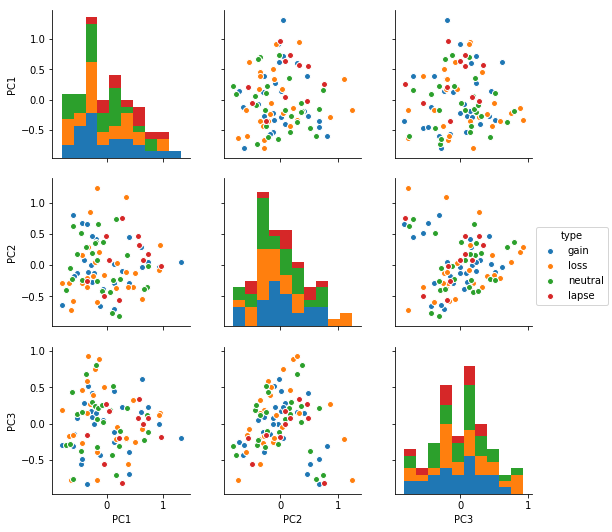

In [5]:
import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, LeaveOneOut
import seaborn as sns

loo=LeaveOneOut()
pca=PCA(n_components=3)
cols=['sub','AOI','train_desc','test_desc','acc','train_test','train_acc']
data=[]
masker=mask_list[1]
svc=sklearn.svm.SVC(C=1.0,
                    kernel='linear')

for i,behavior in enumerate(label_list):
    sub=behavior['sub'].unique()
    func=image.load_img(func_list[i])
    mean_img=image.image.mean_img(func)
    print sub,func_list[i]
    func_filename = func_list[i]
    
    #display(behavioral.head())
    
    
    current_masker=masker
    X = current_masker.fit_transform(func_filename)
    X=sklearn.preprocessing.normalize(X)
    X=sklearn.preprocessing.normalize(X=X, axis=0)
    X=pca.fit_transform(X)
    #don't run now normed_Xtrain=preprocessing.normalize(X_train)
    #don't run now normed_Xtest=preprocessing.normalize(X_test)        
    #Training on affective vs informative (run1 vs run2)
    # validating on affective vs informative (run3 vs run4)
    scores=cross_val_score(svc,X=X,y=behavior.label,cv=loo)
    print np.mean(scores)
    data=pd.DataFrame({'PC1':X[:,0],'PC2':X[:,1],'PC3':X[:,2],'type':behavior.label})
    display(data.groupby(by='type').mean())
    sns.pairplot(data=data,hue='type')
    plt.show()

In [6]:
data=[]
for i,behavior in enumerate(label_list):
    print sub,func_list[i]
    for ii,mask in enumerate(mask_list):
        print('mask number %s'%(ii))
        masker=mask
        sub=behavior['sub'].unique()
        func=image.load_img(func_list[i])
        mean_img=image.image.mean_img(func)
        func_filename = func_list[i]
        conditions = behavior['label']

        # Restrict the analysis to faces and places
        condition_mask = behavior['label'].isin(['loss', 'gain'])
        conditions = conditions[condition_mask]
        X = masker.fit_transform(func_filename)
        # Apply our condition_mask
        X = X[condition_mask]
        scores=cross_val_score(svc,X=X,y=conditions,cv=loo)
        data.append([sub,'LvG',ii,np.mean(scores)])
df_1=pd.DataFrame(data,columns=['sub','test','mask','acc'])


[109] /data/projects/highressingletrial/MVPA/data/sub-124/DelgadoCard_func.nii.gz
mask number 0
mask number 1
mask number 2
mask number 3
mask number 4
mask number 5
mask number 6
[124] /data/projects/highressingletrial/MVPA/data/sub-118/DelgadoCard_func.nii.gz
mask number 0
mask number 1
mask number 2
mask number 3
mask number 4
mask number 5
mask number 6
[118] /data/projects/highressingletrial/MVPA/data/sub-114/DelgadoCard_func.nii.gz
mask number 0
mask number 1
mask number 2
mask number 3
mask number 4
mask number 5
mask number 6
[114] /data/projects/highressingletrial/MVPA/data/sub-115/DelgadoCard_func.nii.gz
mask number 0
mask number 1
mask number 2
mask number 3
mask number 4
mask number 5
mask number 6
[115] /data/projects/highressingletrial/MVPA/data/sub-106/DelgadoCard_func.nii.gz
mask number 0
mask number 1
mask number 2
mask number 3
mask number 4
mask number 5
mask number 6
[106] /data/projects/highressingletrial/MVPA/data/sub-113/DelgadoCard_func.nii.gz
mask number 0
mask

NameError: name 'acc' is not defined

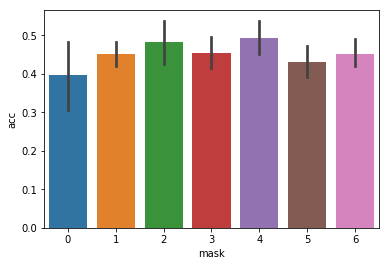

In [8]:
sns.barplot(x='mask',y='acc',data=df_1)
plt.show()

[109] /data/projects/highressingletrial/MVPA/data/sub-124/DelgadoCard_func.nii.gz
mask number 0
mask number 1
mask number 2
mask number 3
mask number 4
mask number 5
mask number 6
[124] /data/projects/highressingletrial/MVPA/data/sub-118/DelgadoCard_func.nii.gz
mask number 0
mask number 1
mask number 2
mask number 3
mask number 4
mask number 5
mask number 6
[118] /data/projects/highressingletrial/MVPA/data/sub-114/DelgadoCard_func.nii.gz
mask number 0
mask number 1
mask number 2
mask number 3
mask number 4
mask number 5
mask number 6
[114] /data/projects/highressingletrial/MVPA/data/sub-115/DelgadoCard_func.nii.gz
mask number 0
mask number 1
mask number 2
mask number 3
mask number 4
mask number 5
mask number 6
[115] /data/projects/highressingletrial/MVPA/data/sub-106/DelgadoCard_func.nii.gz
mask number 0
mask number 1
mask number 2
mask number 3
mask number 4
mask number 5
mask number 6
[106] /data/projects/highressingletrial/MVPA/data/sub-113/DelgadoCard_func.nii.gz
mask number 0
mask

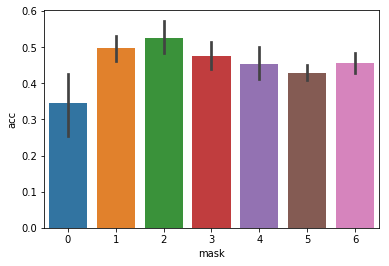

In [10]:
data=[]
for i,behavior in enumerate(label_list):
    print sub,func_list[i]
    for ii,mask in enumerate(mask_list):
        print('mask number %s'%(ii))
        masker=mask
        sub=behavior['sub'].unique()
        func=image.load_img(func_list[i])
        mean_img=image.image.mean_img(func)
        func_filename = func_list[i]
        conditions = behavior['label']

        # Restrict the analysis to faces and places
        condition_mask = behavior['label'].isin(['loss', 'neutral'])
        conditions = conditions[condition_mask]
        X = masker.fit_transform(func_filename)
        # Apply our condition_mask
        X = X[condition_mask]
        scores=cross_val_score(svc,X=X,y=conditions,cv=loo)
        data.append([sub,'LvG',ii,np.mean(scores)])
df_2=pd.DataFrame(data,columns=['sub','test','mask','acc'])
sns.barplot(x='mask',y='acc',data=df_2)
plt.show()

[109] /data/projects/highressingletrial/MVPA/data/sub-124/DelgadoCard_func.nii.gz
mask number 0
mask number 1
mask number 2
mask number 3
mask number 4
mask number 5
mask number 6
[124] /data/projects/highressingletrial/MVPA/data/sub-118/DelgadoCard_func.nii.gz
mask number 0
mask number 1
mask number 2
mask number 3
mask number 4
mask number 5
mask number 6
[118] /data/projects/highressingletrial/MVPA/data/sub-114/DelgadoCard_func.nii.gz
mask number 0
mask number 1
mask number 2
mask number 3
mask number 4
mask number 5
mask number 6
[114] /data/projects/highressingletrial/MVPA/data/sub-115/DelgadoCard_func.nii.gz
mask number 0
mask number 1
mask number 2
mask number 3
mask number 4
mask number 5
mask number 6
[115] /data/projects/highressingletrial/MVPA/data/sub-106/DelgadoCard_func.nii.gz
mask number 0
mask number 1
mask number 2
mask number 3
mask number 4
mask number 5
mask number 6
[106] /data/projects/highressingletrial/MVPA/data/sub-113/DelgadoCard_func.nii.gz
mask number 0
mask

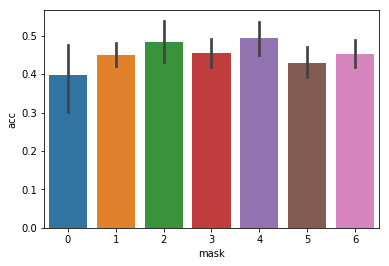

In [11]:
data=[]
for i,behavior in enumerate(label_list):
    print sub,func_list[i]
    for ii,mask in enumerate(mask_list):
        print('mask number %s'%(ii))
        masker=mask
        sub=behavior['sub'].unique()
        func=image.load_img(func_list[i])
        mean_img=image.image.mean_img(func)
        func_filename = func_list[i]
        conditions = behavior['label']

        # Restrict the analysis to faces and places
        condition_mask = behavior['label'].isin(['loss', 'gain'])
        conditions = conditions[condition_mask]
        X = masker.fit_transform(func_filename)
        # Apply our condition_mask
        X = X[condition_mask]
        scores=cross_val_score(svc,X=X,y=conditions,cv=loo)
        data.append([sub,'LvG',ii,np.mean(scores)])
df_3=pd.DataFrame(data,columns=['sub','test','mask','acc'])
sns.barplot(x='mask',y='acc',data=df_3)
plt.show()